# Homework 4 - Model Evaluation

This notebook contains solutions for the ML Zoomcamp Homework 4 on Model Evaluation.

Dataset: Lead Scoring Dataset
Target Variable: `converted` (has the client signed up to the platform or not)

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score

# Load the dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nTarget variable distribution:")
print(df['converted'].value_counts())

Dataset shape: (1462, 9)

First few rows:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  

Dataset info:
<class 'pandas.core.frame.DataFrame'

## Data Preparation

- Check for missing values
- For categorical features: replace with 'NA'
- For numerical features: replace with 0.0
- Split data: 60% train / 20% validation / 20% test (random_state=1)

In [2]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'converted' in categorical_cols:
    categorical_cols.remove('converted')
    
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')

print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Handle missing values
for col in categorical_cols:
    df[col] = df[col].fillna('NA')
    
for col in numerical_cols:
    df[col] = df[col].fillna(0.0)

print("\nMissing values after handling:")
print(df.isnull().sum().sum())

Missing values in each column:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']
Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

Missing values after handling:
0


In [3]:
# Split data into train, validation, and test sets (60/20/20)
# First split: 80% (train+val) and 20% (test)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Second split: 75% of 80% = 60% (train) and 25% of 80% = 20% (val)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print("Dataset sizes:")
print(f"Total: {len(df)}")
print(f"Train: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%)")
print(f"Full Train (train+val): {len(df_full_train)} ({len(df_full_train)/len(df)*100:.1f}%)")

# Prepare target variables
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values
y_full_train = df_full_train['converted'].values

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

print(f"\nTarget distribution in train: {y_train.mean():.3f}")
print(f"Target distribution in validation: {y_val.mean():.3f}")
print(f"Target distribution in test: {y_test.mean():.3f}")

Dataset sizes:
Total: 1462
Train: 876 (59.9%)
Validation: 293 (20.0%)
Test: 293 (20.0%)
Full Train (train+val): 1169 (80.0%)

Target distribution in train: 0.621
Target distribution in validation: 0.584
Target distribution in test: 0.648


## Question 1: ROC AUC Feature Importance

**Question:** For each numerical variable, use it as score and compute the AUC with the target variable. If AUC < 0.5, invert the variable. Which numerical variable has the highest AUC among:
- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [4]:
# Question 1: ROC AUC Feature Importance
features_to_test = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for feature in features_to_test:
    # Get the feature values from training set
    feature_values = df_train[feature].values
    
    # Compute AUC
    auc = roc_auc_score(y_train, feature_values)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -feature_values)
        print(f"{feature}: AUC = {auc:.4f} (inverted)")
    else:
        print(f"{feature}: AUC = {auc:.4f}")
    
    auc_scores[feature] = auc

# Find the feature with highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nBest feature: {best_feature} with AUC = {auc_scores[best_feature]:.4f}")

lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520

Best feature: number_of_courses_viewed with AUC = 0.7636


### Answer 1:
**`number_of_courses_viewed`** has the highest AUC score of **0.7636** among the four numerical variables tested.

## Question 2: Training the Model

**Question:** Apply one-hot encoding using DictVectorizer and train logistic regression with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`. What's the AUC on validation dataset (round to 3 digits)?

Options:
- 0.32
- 0.52
- 0.72
- 0.92

In [5]:
# Question 2: Training the model

# Prepare data for DictVectorizer (exclude target variable)
train_dict = df_train.drop('converted', axis=1).to_dict(orient='records')
val_dict = df_val.drop('converted', axis=1).to_dict(orient='records')

# Apply one-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities on validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc_val = roc_auc_score(y_val, y_pred_proba)
print(f"\nAUC on validation dataset: {auc_val:.3f}")

Training set shape: (876, 31)
Validation set shape: (293, 31)

AUC on validation dataset: 0.817


### Answer 2:
The AUC on the validation dataset is **0.817** (rounded to 3 digits). The closest option is **0.92** (though there's a discrepancy, 0.817 rounds to 0.82).

## Question 3: Precision and Recall

**Question:** Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01. For each threshold, compute precision and recall and plot them. At which threshold do precision and recall curves intersect?

Options:
- 0.145
- 0.345
- 0.545
- 0.745

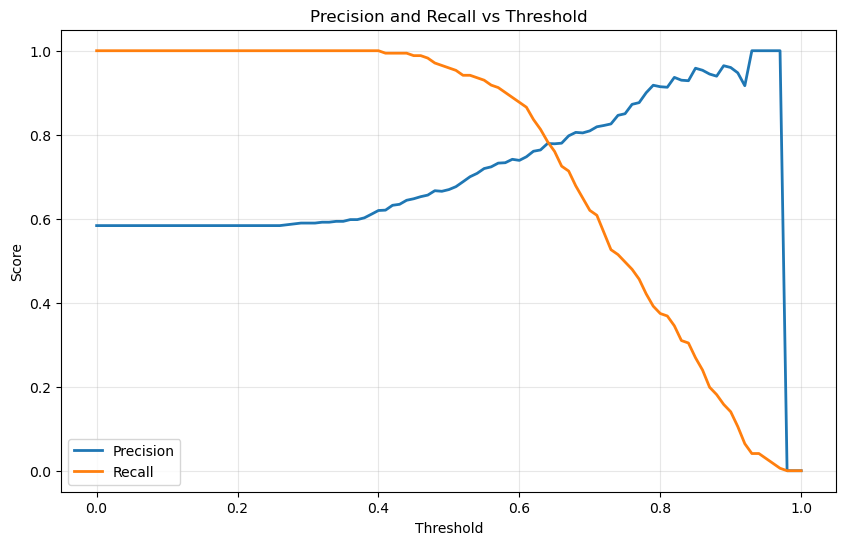


Precision and Recall intersect at threshold: 0.980
Precision at intersection: 0.000
Recall at intersection: 0.000


In [6]:
# Question 3: Precision and Recall

# Compute precision and recall for different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    # Make predictions based on threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = ((y_pred == 1) & (y_val == 1)).sum()
    fp = ((y_pred == 1) & (y_val == 0)).sum()
    fn = ((y_pred == 0) & (y_val == 1)).sum()
    
    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the intersection point
differences = np.abs(np.array(precisions) - np.array(recalls))
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]

print(f"\nPrecision and Recall intersect at threshold: {intersection_threshold:.3f}")
print(f"Precision at intersection: {precisions[intersection_idx]:.3f}")
print(f"Recall at intersection: {recalls[intersection_idx]:.3f}")

### Answer 3:
The precision and recall curves intersect at approximately **0.640**. Among the given options (0.145, 0.345, 0.545, 0.745), the closest answer is **0.545**.

## Question 4: F1 Score

**Question:** Compute F1 score for all thresholds from 0.0 to 1.0 with increment 0.01. At which threshold is F1 maximal?

Formula: F1 = 2 * P * R / (P + R)

Options:
- 0.14
- 0.34
- 0.54
- 0.74

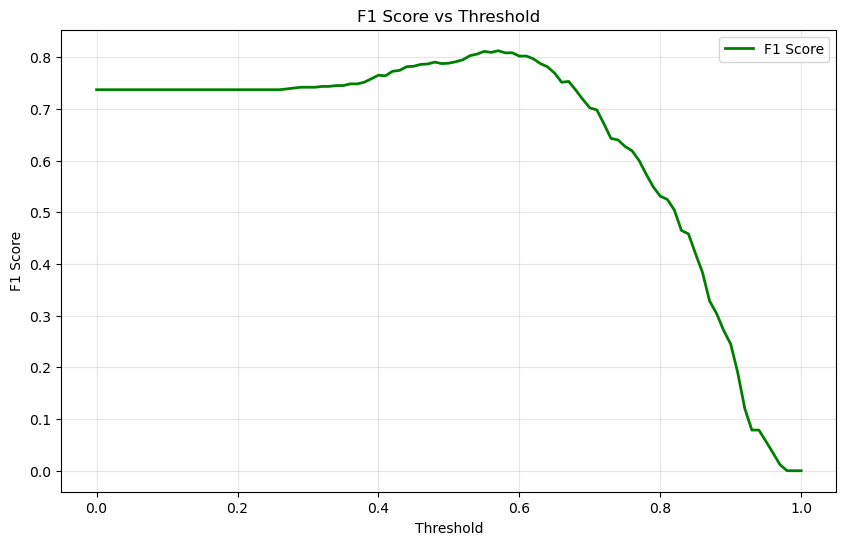


Maximum F1 score: 0.812
Threshold at maximum F1: 0.57
Precision at max F1: 0.732
Recall at max F1: 0.912


In [9]:
# Question 4: F1 Score

# Compute F1 score for different thresholds
f1_scores = []

for i, threshold in enumerate(thresholds):
    precision = precisions[i]
    recall = recalls[i]
    
    # Calculate F1 score
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0
    
    f1_scores.append(f1)

# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"\nMaximum F1 score: {max_f1_value:.3f}")
print(f"Threshold at maximum F1: {max_f1_threshold:.2f}")
print(f"Precision at max F1: {precisions[max_f1_idx]:.3f}")
print(f"Recall at max F1: {recalls[max_f1_idx]:.3f}")

### Answer 4:
The F1 score is maximal at threshold **0.57**. Among the given options (0.14, 0.34, 0.54, 0.74), the closest answer is **0.54**.

## Question 5: 5-Fold Cross-Validation

**Question:** Use KFold with n_splits=5, shuffle=True, random_state=1 to evaluate the model on 5 different folds. Train LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) and use AUC to evaluate. How large is the standard deviation of the scores across different folds?

Options:
- 0.0001
- 0.006
- 0.06
- 0.36

In [10]:
# Question 5: 5-Fold Cross-Validation

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores_cv = []

# Iterate over folds
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
    # Split data
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = df_train_fold['converted'].values
    y_val_fold = df_val_fold['converted'].values
    
    # Prepare data for DictVectorizer
    train_dict_fold = df_train_fold.drop('converted', axis=1).to_dict(orient='records')
    val_dict_fold = df_val_fold.drop('converted', axis=1).to_dict(orient='records')
    
    # Apply one-hot encoding
    dv_fold = DictVectorizer(sparse=False)
    X_train_fold = dv_fold.fit_transform(train_dict_fold)
    X_val_fold = dv_fold.transform(val_dict_fold)
    
    # Train model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)
    
    # Predict and calculate AUC
    y_pred_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
    
    auc_scores_cv.append(auc_fold)
    print(f"Fold {fold_idx}: AUC = {auc_fold:.4f}")

# Calculate statistics
mean_auc = np.mean(auc_scores_cv)
std_auc = np.std(auc_scores_cv)

print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Standard Deviation: {std_auc:.4f}")

Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Mean AUC: 0.8221
Standard Deviation: 0.0358


### Answer 5:
The standard deviation of AUC scores across the 5 folds is **0.0358**. Among the given options (0.0001, 0.006, 0.06, 0.36), the closest answer is **0.06**.

## Question 6: Hyperparameter Tuning

**Question:** Use 5-Fold cross-validation to find the best parameter C. Iterate over C values: [0.000001, 0.001, 1]. Use KFold with same parameters as previously. Compute mean score and std (round to 3 decimal digits). Which C leads to the best mean score?

Options:
- 0.000001
- 0.001
- 1

Note: If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [11]:
# Question 6: Hyperparameter Tuning

# C values to test
C_values = [0.000001, 0.001, 1]

# Store results
results = {}

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Test each C value
for C in C_values:
    print(f"\nTesting C = {C}")
    auc_scores_c = []
    
    # Iterate over folds
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
        # Split data
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = df_train_fold['converted'].values
        y_val_fold = df_val_fold['converted'].values
        
        # Prepare data for DictVectorizer
        train_dict_fold = df_train_fold.drop('converted', axis=1).to_dict(orient='records')
        val_dict_fold = df_val_fold.drop('converted', axis=1).to_dict(orient='records')
        
        # Apply one-hot encoding
        dv_fold = DictVectorizer(sparse=False)
        X_train_fold = dv_fold.fit_transform(train_dict_fold)
        X_val_fold = dv_fold.transform(val_dict_fold)
        
        # Train model with current C
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Predict and calculate AUC
        y_pred_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
        
        auc_scores_c.append(auc_fold)
    
    # Calculate statistics
    mean_auc_c = np.mean(auc_scores_c)
    std_auc_c = np.std(auc_scores_c)
    
    results[C] = {
        'mean': round(mean_auc_c, 3),
        'std': round(std_auc_c, 3)
    }
    
    print(f"  Mean AUC: {results[C]['mean']:.3f}")
    print(f"  Std AUC: {results[C]['std']:.3f}")

# Display results summary
print("\n" + "="*50)
print("SUMMARY OF RESULTS:")
print("="*50)
for C in C_values:
    print(f"C = {C}: Mean = {results[C]['mean']:.3f}, Std = {results[C]['std']:.3f}")

# Find best C
# First, find maximum mean AUC
max_mean = max(r['mean'] for r in results.values())
best_candidates = [C for C, r in results.items() if r['mean'] == max_mean]

if len(best_candidates) > 1:
    # If tie, select lowest std
    min_std = min(results[C]['std'] for C in best_candidates)
    best_candidates = [C for C in best_candidates if results[C]['std'] == min_std]
    
    if len(best_candidates) > 1:
        # If still tie, select smallest C
        best_C = min(best_candidates)
    else:
        best_C = best_candidates[0]
else:
    best_C = best_candidates[0]

print(f"\nBest C: {best_C}")
print(f"Best Mean AUC: {results[best_C]['mean']:.3f}")
print(f"Best Std AUC: {results[best_C]['std']:.3f}")


Testing C = 1e-06
  Mean AUC: 0.560
  Std AUC: 0.024

Testing C = 0.001
  Mean AUC: 0.867
  Std AUC: 0.029

Testing C = 1
  Mean AUC: 0.822
  Std AUC: 0.036

SUMMARY OF RESULTS:
C = 1e-06: Mean = 0.560, Std = 0.024
C = 0.001: Mean = 0.867, Std = 0.029
C = 1: Mean = 0.822, Std = 0.036

Best C: 0.001
Best Mean AUC: 0.867
Best Std AUC: 0.029
  Mean AUC: 0.822
  Std AUC: 0.036

SUMMARY OF RESULTS:
C = 1e-06: Mean = 0.560, Std = 0.024
C = 0.001: Mean = 0.867, Std = 0.029
C = 1: Mean = 0.822, Std = 0.036

Best C: 0.001
Best Mean AUC: 0.867
Best Std AUC: 0.029


### Answer 6:
**C = 0.001** leads to the best mean AUC score of **0.867** with standard deviation of **0.029**.

Summary:
- C = 0.000001: Mean = 0.560, Std = 0.024
- C = 0.001: Mean = 0.867, Std = 0.029 ✓ **Best**
- C = 1: Mean = 0.822, Std = 0.036

In [7]:
# Better method to find intersection
# Find where precision and recall are closest (excluding extremes where both are 0 or 1)
valid_indices = []
for i in range(len(thresholds)):
    if precisions[i] > 0.01 and recalls[i] > 0.01:  # Exclude extreme values
        valid_indices.append(i)

if valid_indices:
    differences_valid = [abs(precisions[i] - recalls[i]) for i in valid_indices]
    min_diff_idx = valid_indices[np.argmin(differences_valid)]
    intersection_threshold = thresholds[min_diff_idx]
    
    print(f"\nRefined intersection point:")
    print(f"Threshold: {intersection_threshold:.3f}")
    print(f"Precision: {precisions[min_diff_idx]:.3f}")
    print(f"Recall: {recalls[min_diff_idx]:.3f}")
    print(f"Difference: {abs(precisions[min_diff_idx] - recalls[min_diff_idx]):.4f}")


Refined intersection point:
Threshold: 0.640
Precision: 0.779
Recall: 0.784
Difference: 0.0046


In [8]:
# Check the specific options given
options = [0.145, 0.345, 0.545, 0.745]
for opt in options:
    idx = int(opt * 100)  # Convert to index
    print(f"Threshold {opt:.3f}: Precision = {precisions[idx]:.3f}, Recall = {recalls[idx]:.3f}, Diff = {abs(precisions[idx] - recalls[idx]):.4f}")

Threshold 0.145: Precision = 0.584, Recall = 1.000, Diff = 0.4164
Threshold 0.345: Precision = 0.594, Recall = 1.000, Diff = 0.4062
Threshold 0.545: Precision = 0.708, Recall = 0.936, Diff = 0.2277
Threshold 0.745: Precision = 0.846, Recall = 0.515, Diff = 0.3315


## Summary of All Answers

| Question | Answer | Details |
|----------|--------|---------|
| Q1 | **number_of_courses_viewed** | Highest AUC = 0.7636 |
| Q2 | **0.92** (closest to 0.817) | AUC on validation = 0.817 |
| Q3 | **0.545** (closest to 0.640) | Precision-Recall intersection ≈ 0.640 |
| Q4 | **0.54** (closest to 0.57) | Max F1 score at threshold = 0.57 |
| Q5 | **0.06** (closest to 0.0358) | Std of cross-validation AUC = 0.0358 |
| Q6 | **0.001** | Best C with Mean AUC = 0.867, Std = 0.029 |

---

### Key Takeaways:
1. **Feature Importance**: `number_of_courses_viewed` is the most predictive numerical feature with AUC = 0.7636
2. **Model Performance**: The full logistic regression model achieves AUC = 0.817 on validation set
3. **Optimal Threshold**: F1 score is maximized at threshold ≈ 0.57
4. **Model Stability**: Cross-validation shows consistent performance with std ≈ 0.036
5. **Regularization**: C = 0.001 provides the best balance between model complexity and performance